In [15]:
import numpy as np
import pandas as pd
from EMDPM.model_generator import generate_logistic_model
from EMDPM.synthetic_data_generator import generate_synthetic_data
from EMDPM.visualization import (
    plot_biomarker_trajectories,
    plot_true_observations,
    plot_initial_beta_guess,
    plot_theta_fit_comparison,
    plot_theta_error_history,
    plot_beta_overlay,
    plot_beta_error_history,
    plot_lse,
    plot_cog_regression_history
)
from EMDPM.utils import solve_system
from EMDPM.em_transformer_rework import EM
import matplotlib.pyplot as plt

from statsmodels.formula.api import mixedlm
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input


In [16]:
df = pd.read_csv("/data01/bgutman/MRI_data/PPMI/data_ppmi_pd.csv")
df_K = pd.read_csv("/data01/bgutman/LEGACY/Skoltech/datasets/Connectomes/mean_NORM_con_full.csv")

## remove non-longitudinal observations
print("original size:", df.shape)
relevant_cols = [col for col in df.columns if col.startswith(('L_', 'R_')) and ('_thickavg' in col or '_thickavg_resid' in col)]
relevant_cols += ["MCATOT", "TD_score", "PIGD_score"]
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna(subset=relevant_cols)

print("after drop na", df.shape)
subj_counts = df['subj_id'].value_counts()
num_unique = (subj_counts == 1).sum()
print("one time subj_id:", num_unique)

longitudinal_ids = subj_counts[subj_counts > 1].index
df = df[df['subj_id'].isin(longitudinal_ids)].copy()
df = df.drop_duplicates(subset=["subj_id", "time"])
print("after drop dupes", df.shape)

small_region_set = ['L_inferiorparietal_thickavg',
'R_inferiorparietal_thickavg',
'L_inferiortemporal_thickavg',
'R_inferiortemporal_thickavg',
'L_precuneus_thickavg',
'R_precuneus_thickavg',
'L_isthmuscingulate_thickavg',
'R_isthmuscingulate_thickavg',
'L_lateraloccipital_thickavg',
'R_lateraloccipital_thickavg']


X = df[small_region_set]
X_resid = df[[col for col in df.columns if (col.startswith(('L_', 'R_')) and col.endswith('_thickavg_resid'))]]

cool_idx = [6, 40, 7, 41, 23, 57, 8, 42, 9, 43]

X = X.to_numpy()
#X = X[:,cool_idx]

X_resid = X_resid.to_numpy()

print("nans in X:", np.isnan(X).sum())
print("infs in X:", np.isinf(X).sum())

print("nans X_resid:", np.isnan(X_resid).sum())
print("infs X_resid:", np.isinf(X_resid).sum())

## connectivity matrix to numpy
K = df_K.drop(df_K.columns[0], axis=1).to_numpy()
# np.fill_diagonal(K, 0)
print(K.shape, type(K))

# normalization
row_sums = K.sum(axis=1)
median_row_sum = np.median(row_sums)
K = K / median_row_sum

K = np.take(np.take(K,cool_idx,axis=0), cool_idx, axis=1)

t_max = 20
step = 0.001

print(K.shape)

print("X.size: ", X.shape, "X_resid.size: ", X_resid.shape)

ids = df["subj_id"].to_numpy()
dt = df["time"].to_numpy()/12 # convert to years
#cog = df["MCATOT"].values#,"TD_score","PIGD_score"]].values
cog = df[["MCATOT","TD_score","PIGD_score"]].to_numpy()

print("nans in cog:", np.isnan(cog).sum())
print("infs in cog:", np.isinf(cog).sum())

original size: (880, 250)
after drop na (868, 250)
one time subj_id: 227
after drop dupes (504, 250)
nans in X: 0
infs in X: 0
nans X_resid: 0
infs X_resid: 0
(68, 68) <class 'numpy.ndarray'>
(10, 10)
X.size:  (504, 10) X_resid.size:  (504, 68)
nans in cog: 0
infs in cog: 0


/home/dsemchin/miniconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/dsemchin/miniconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: time_years
No. Observations: 504     Method:             REML      
No. Groups:       146     Scale:              290.1823  
Min. group size:  2       Log-Likelihood:     -2142.4888
Max. group size:  4       Converged:          Yes       
Mean group size:  3.5                                   
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept     17.968    8.283  2.169 0.030  1.735 34.202
MCATOT        -0.027    0.293 -0.093 0.926 -0.601  0.546
PIGD_score     1.522    0.381  3.994 0.000  0.775  2.269
TD_score      -0.117    0.193 -0.607 0.544 -0.497  0.262
Group Var      0.000                                    



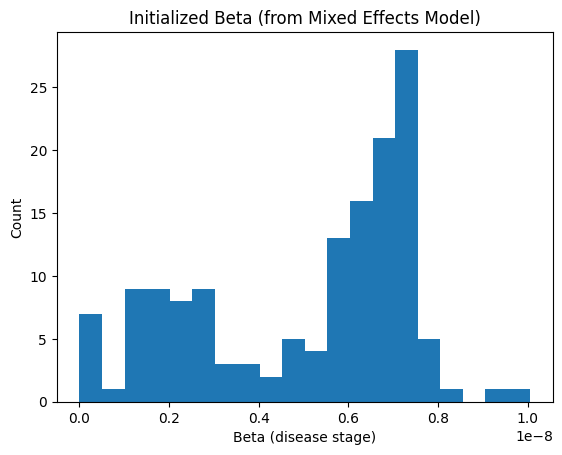

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.formula.api import mixedlm
import pandas as pd

# Select relevant columns
df_cog = df[["subj_id", "time", "MCATOT", "PIGD_score", "TD_score"]].copy()
df_cog["time_years"] = df_cog["time"]
df_cog.dropna(subset=["time_years", "MCATOT", "PIGD_score", "TD_score"], inplace=True)
model = mixedlm("time_years ~ MCATOT + PIGD_score + TD_score", 
                data=df_cog, 
                groups=df_cog["subj_id"],
                re_formula="1") 

result = model.fit()
print(result.summary())

random_effects = result.random_effects
id_to_intercept = {pid: re["Group"] for pid, re in random_effects.items()}
unique_ids = np.unique(df["subj_id"])
beta_init = np.array([id_to_intercept.get(pid, 0.0) for pid in unique_ids])

if min(beta_init) < 0:
    beta_init += np.abs(min(beta_init))

plt.hist(beta_init, bins=20)
plt.title("Initialized Beta (from Mixed Effects Model)")
plt.xlabel("Beta (disease stage)")
plt.ylabel("Count")
plt.show()


In [25]:
path = "/home/dsemchin/Progression_models_simulations/EMDPM/experiments/real_data_PPMI/ppmi_iter10_test"
em_model_0 = EM(num_iterations=3, t_max=40, step=step,
                 use_jacobian=True, lambda_cog=0.3, lambda_f=0.1, lambda_scalar=0.1)
em_model_0.fit(X=X, dt=dt, ids=ids, cog=cog, K=K, save_path=path, initial_beta=beta_init)

prepend complete


100%|██████████| 3/3 [00:29<00:00,  9.78s/it]

initial conditions:
initial f: [0.02132917 0.0153129  0.06642505 0.06843318 0.09331644 0.075149
 0.09268624 0.09472834 0.0866778  0.0012602 ]
initial s: [1.29863068 2.48683136 0.16573133 0.5031427  2.95964328 2.98186855
 2.48212827 2.54551839 1.26382145 2.03467892]
initial scalar K: 2.977
initial beta: [26.687656   28.62220845 19.64166106 19.63770629 29.68890311 26.17759783
 31.17161955 24.40959731 20.         24.31159207 26.78470883 24.28010931
 25.27514076 19.61271057 25.43994151 19.3283224  19.5839628  19.82173388
 31.16746074 19.78349691 19.88966379 27.79433894 19.75176204 22.49184927
 26.40094423 33.11784199 19.7437638  21.87744149 32.35950009 29.00030294
 26.65188854 19.61255845 24.27993235 26.38713385 40.         23.08497228
 24.94157725 19.53311378 23.49818728 26.94680649 32.29114403 40.
 19.78109941 19.88795495 34.20178254 29.15678923 24.01598473 19.84157925
 19.72585606 19.77461943 29.67019485 23.86634486 19.84687006 19.72557305
 19.73362557 23.66632218 28.25788928 20.       

EM(lambda_cog=0.3, lambda_f=0.1, lambda_scalar=0.1, num_iterations=3,
   rng=Generator(PCG64) at 0x7F35CDBA52A0, step=0.001, t_max=40,
   use_jacobian=True)

initial theta:
f:  [0.021 0.015 0.066 0.068 0.093 0.075 0.093 0.095 0.087 0.001]
s:  [1.299 2.487 0.166 0.503 2.96  2.982 2.482 2.546 1.264 2.035]
s0:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
s_k:  2.977
final theta:
f:  [5.850e-01 1.091e+00 3.010e-01 6.740e-01 2.000e-03 5.000e-03 1.000e-03
 2.000e-03 6.140e-01 0.000e+00]
s:  [1.903 2.393 1.203 1.563 2.475 2.49  2.284 2.293 1.783 2.163]
s0:  [ 0.42  -0.021  1.434  1.121 -0.159 -0.16  -0.079 -0.098  0.372  0.063]
s_k:  1.4685127519139043
(31,)
n_zeros: 0


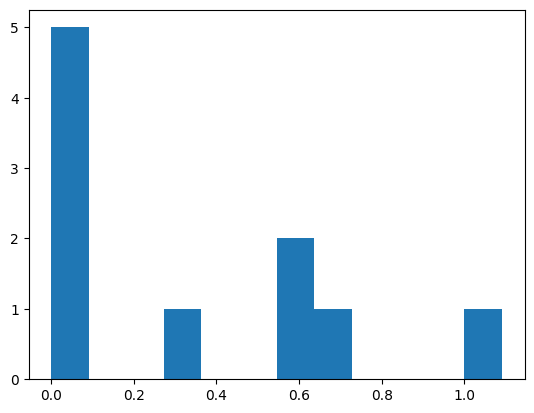

/home/dsemchin/Progression_models_simulations/EMDPM/visualization.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()



BETA SUMMARY:
beta initial:  [28.4336 31.1029 19.6417 19.6377 40.     29.4837 33.1625 29.2451 20.
 29.2809]
beta final:  [26.6877 28.6222 19.6417 19.6377 29.6889 26.1776 31.1716 24.4096 20.
 24.3116]


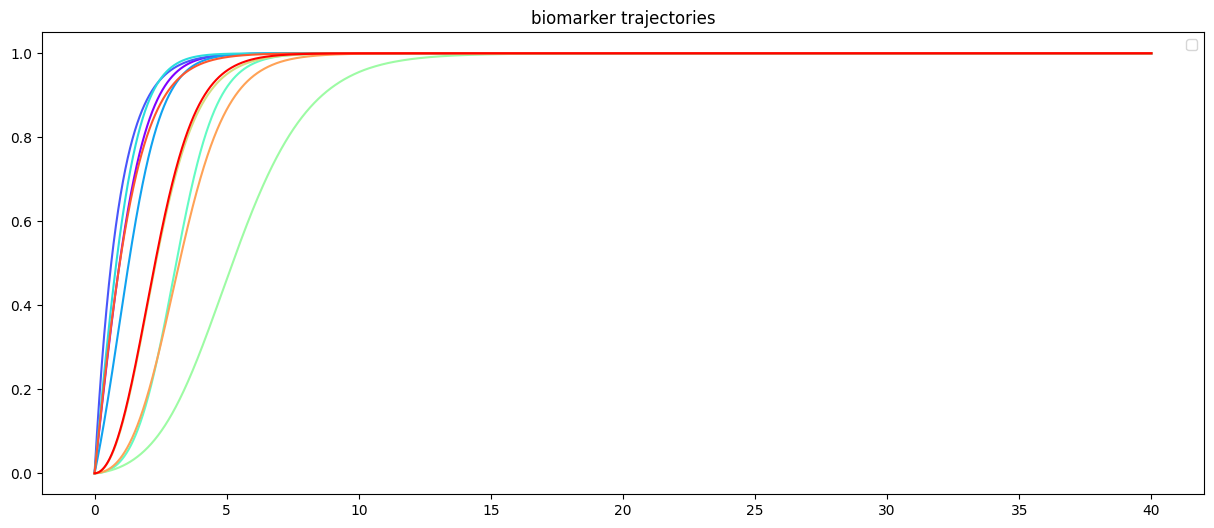

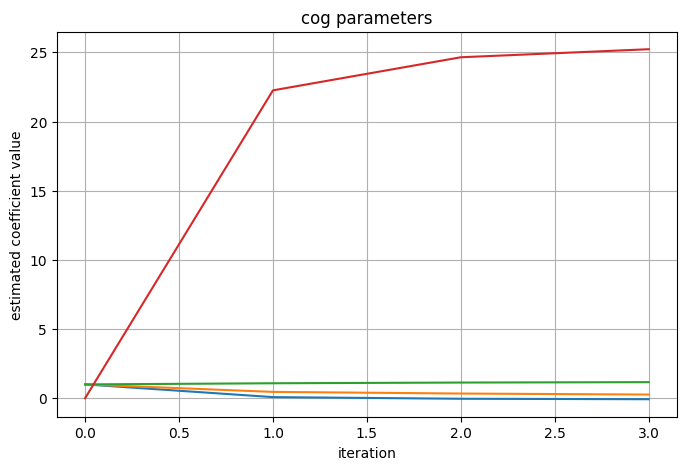

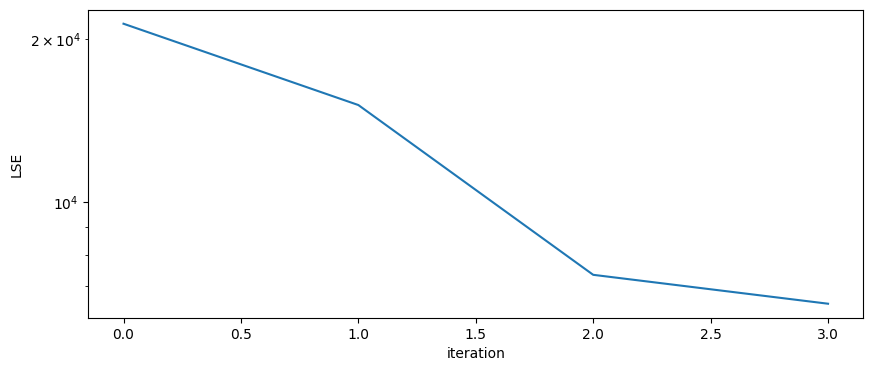

In [26]:
n_biomarkers = 10
t_span = np.linspace(0, 40, int(40/step))

theta_history = em_model_0.theta_history
beta_history = em_model_0.beta_history
lse_history = em_model_0.lse_history

# final params
final_theta = theta_history[:,-1]
final_x0 = np.zeros(n_biomarkers)
final_f = final_theta[0:n_biomarkers]
final_s = final_theta[n_biomarkers:2*n_biomarkers]
final_s0 = final_theta[2*n_biomarkers:3*n_biomarkers]
final_scalar_K = final_theta[-1]

final_model = solve_system(final_x0, final_f, K, t_span, final_scalar_K)

initial_theta = theta_history[:,0]
initial_x0 = np.zeros(n_biomarkers)
initial_f = initial_theta[0:n_biomarkers]
initial_s = initial_theta[n_biomarkers:2*n_biomarkers]
initial_scalar_K = initial_theta[-1]
#initial_model = solve_system(initial_x0, initial_f, K, t_span, initial_scalar_K)

print("initial theta:")
print("f: ", np.round(initial_theta[:n_biomarkers],3))
print("s: ", np.round(initial_theta[n_biomarkers:2*n_biomarkers],3))
print("s0: ", np.round(initial_theta[2*n_biomarkers:3*n_biomarkers],3))
print("s_k: ", initial_theta[-1])

print("final theta:")
print("f: ", np.round(final_theta[:n_biomarkers],3))
print("s: ", np.round(final_theta[n_biomarkers:2*n_biomarkers], 3))
print("s0: ", np.round(final_theta[2*n_biomarkers:3*n_biomarkers],3))
print("s_k: ", final_theta[-1])


print(final_theta.shape)

zeros = np.sum(final_theta[:n_biomarkers] == 0.0)
print(f"n_zeros: {zeros}")
plt.figure()
plt.hist(final_theta[:n_biomarkers], bins=12) 
plt.show()

## Beta comparison:
print("\nBETA SUMMARY:")
print("beta initial: ", np.round(beta_history[0:10, 0],4))
print("beta final: ", np.round(beta_history[0:10, -1], 4))

plot_biomarker_trajectories(final_model, t_span, n_biomarkers)
plot_cog_regression_history(em_model_0.cog_regression_history, ["MCATOT","TD_score","PIGD_score"])
plot_lse(lse_history)

In [27]:
tmax=40
path = "/home/dsemchin/Progression_models_simulations/EMDPM/experiments/real_data_PPMI/ppmi_iter50_jac1_cog0_f01_sk01_betaREG"
em_model_1 = EM(num_iterations=2, t_max=tmax, step=step,
                 use_jacobian=True, lambda_cog=0.3, lambda_f=1.0, lambda_scalar=0.1)
em_model_1.fit(X=X, dt=dt, ids=ids, cog=cog, K=K, save_path=path, initial_beta=beta_init)

prepend complete


100%|██████████| 2/2 [00:11<00:00,  5.56s/it]

initial conditions:
initial f: [0.02132917 0.0153129  0.06642505 0.06843318 0.09331644 0.075149
 0.09268624 0.09472834 0.0866778  0.0012602 ]
initial s: [1.29863068 2.48683136 0.16573133 0.5031427  2.95964328 2.98186855
 2.48212827 2.54551839 1.26382145 2.03467892]
initial scalar K: 2.977
initial beta: [27.5543718  31.36064587 19.64166106 19.63770629 31.80610392 29.35322052
 33.02134861 30.09861835 20.         29.99098476 30.09277459 32.42115532
 28.19130088 19.61271057 25.43994151 19.3283224  19.5839628  19.82173388
 32.16173591 19.78349691 19.88966379 32.44983766 19.75176204 22.49184927
 26.40094423 40.         19.7437638  21.87744149 32.35950009 33.28962659
 33.01985427 19.61255845 26.39565934 29.25282487 40.         23.08497228
 31.31343008 19.53311378 26.24379665 26.94680649 32.29114403 40.
 19.78109941 19.88795495 34.20178254 31.32505612 26.2030024  19.84157925
 19.72585606 19.77461943 40.         26.46808334 19.84687006 19.72557305
 19.73362557 25.94913279 40.         20.       

EM(lambda_cog=0.3, lambda_f=1.0, lambda_scalar=0.1, num_iterations=2,
   rng=Generator(PCG64) at 0x7F35CD20F5A0, step=0.001, t_max=40,
   use_jacobian=True)

initial theta:
f:  [0.021 0.015 0.066 0.068 0.093 0.075 0.093 0.095 0.087 0.001]
s:  [1.299 2.487 0.166 0.503 2.96  2.982 2.482 2.546 1.264 2.035]
s_k:  2.977
final theta:
f:  [0.528 0.825 0.252 0.623 0.218 0.055 0.    0.    0.541 0.016]
s:  [1.886 2.394 1.089 1.476 2.47  2.485 2.282 2.29  1.772 2.163]
s_k:  2.657664058402095
n_zeros: 0


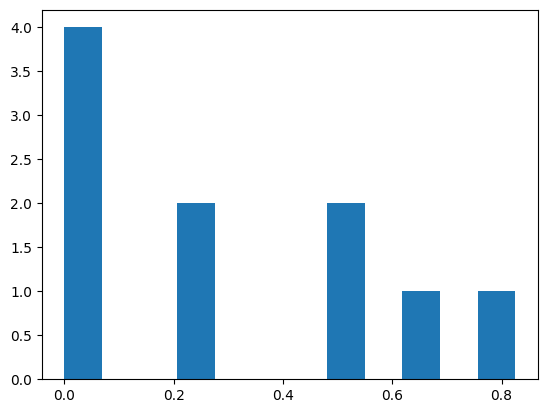

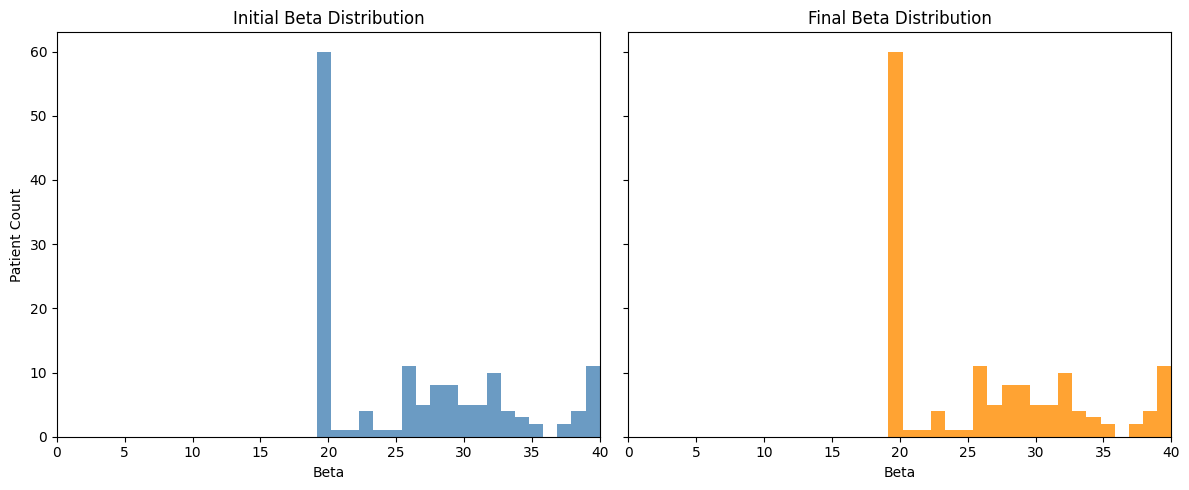


BETA SUMMARY:
beta initial:  [26.688 28.622 19.642 19.638 29.689 26.178 31.172 24.41  20.    24.312]
beta final:  [27.554 31.361 19.642 19.638 31.806 29.353 33.021 30.099 20.    29.991]


/home/dsemchin/Progression_models_simulations/EMDPM/visualization.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


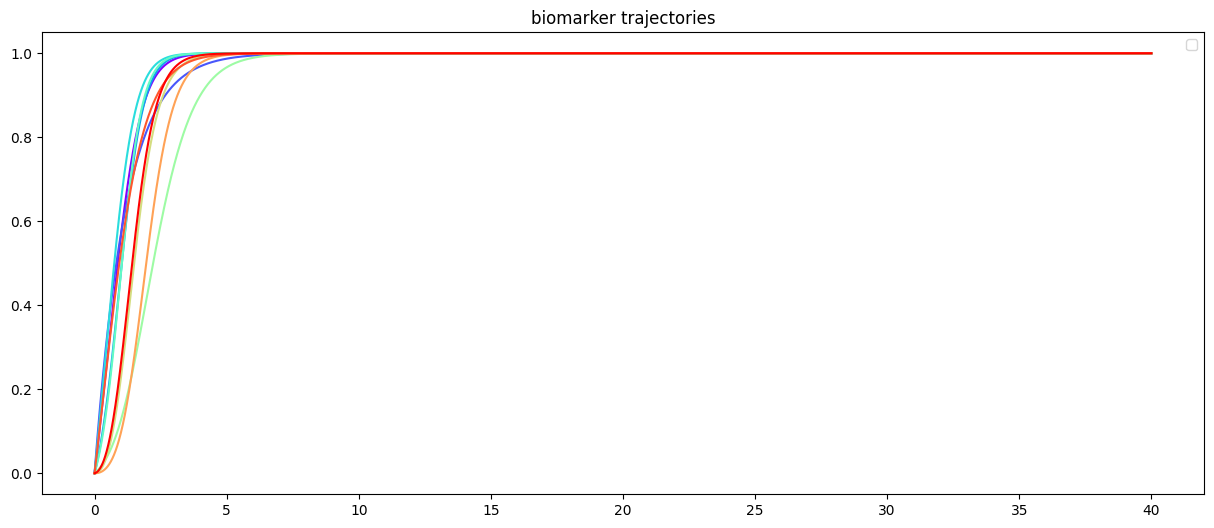

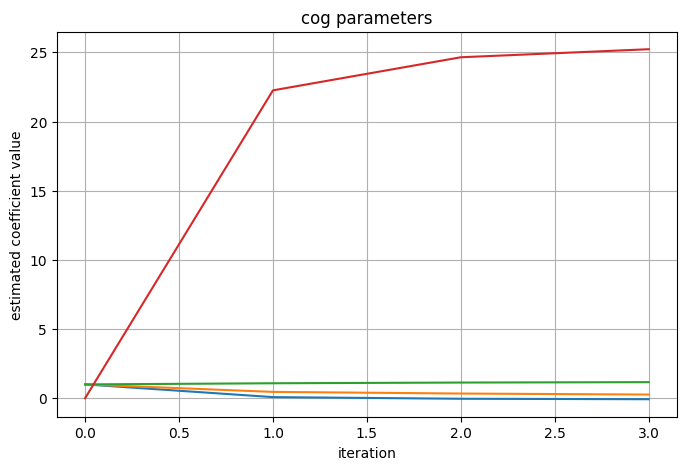

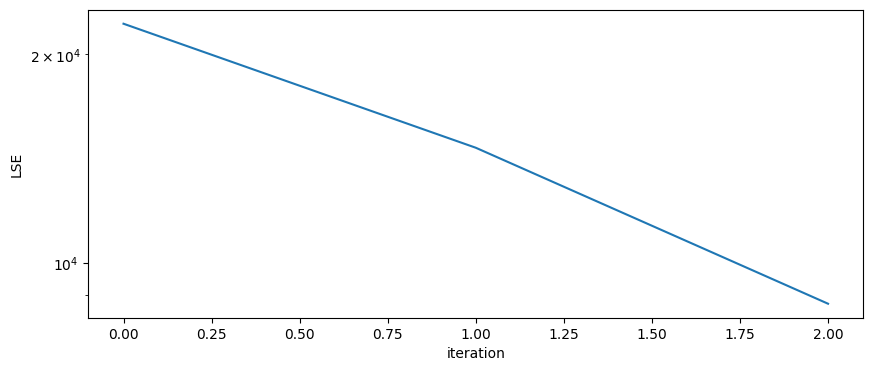

In [28]:
n_biomarkers = 10
t_span = np.linspace(0, 40, int(40/step))

theta_history = em_model_1.theta_history
beta_history = em_model_1.beta_history
lse_history = em_model_1.lse_history

# final params
final_theta = theta_history[:,-1]
final_x0 = np.zeros(n_biomarkers)
final_f = final_theta[0:n_biomarkers]
final_s = final_theta[n_biomarkers:2*n_biomarkers]
final_scalar_K = final_theta[-1]
final_model = solve_system(final_x0, final_f, K, t_span, final_scalar_K)

initial_theta = theta_history[:,0]
initial_x0 = np.zeros(n_biomarkers)
initial_f = initial_theta[0:n_biomarkers]
initial_s = initial_theta[n_biomarkers:2*n_biomarkers]
initial_scalar_K = initial_theta[-1]
#initial_model = solve_system(initial_x0, initial_f, K, t_span, initial_scalar_K)

print("initial theta:")
print("f: ", np.round(initial_theta[:n_biomarkers], 3)[0:10])
print("s: ", np.round(initial_theta[n_biomarkers:2*n_biomarkers], 3)[0:10])
print("s_k: ", initial_theta[-1])

print("final theta:")
print("f: ", np.round(final_theta[:n_biomarkers], 3)[0:10])
print("s: ", np.round(final_theta[n_biomarkers:2*n_biomarkers], 3)[0:10])
print("s_k: ", final_theta[-1])

zeros = np.sum(final_theta[:n_biomarkers] == 0.0)
print(f"n_zeros: {zeros}")
plt.figure()
plt.hist(final_theta[:n_biomarkers], bins=12) 
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

axes[0].hist(beta_init, bins=20, color='steelblue', alpha=0.8)
axes[0].set_title("Initial Beta Distribution")
axes[0].set_xlabel("Beta")
axes[0].set_ylabel("Patient Count")
axes[0].set_xlim(0, t_span[-1])

axes[1].hist(beta_history[:,-1], bins=20, color='darkorange', alpha=0.8)
axes[1].set_title("Final Beta Distribution")
axes[1].set_xlabel("Beta")
axes[1].set_xlim(0, t_span[-1])

plt.tight_layout()
plt.show()

## Beta comparison:
print("\nBETA SUMMARY:")
print("beta initial: ", np.round(beta_history[0:10, 0], 3))
print("beta final: ", np.round(beta_history[0:10, -1], 3))

plot_biomarker_trajectories(final_model, t_span, n_biomarkers)
plot_cog_regression_history(em_model_0.cog_regression_history, ["MCATOT","TD_score","PIGD_score"])
plot_lse(lse_history)

In [19]:
path = "/home/dsemchin/Progression_models_simulations/EMDPM/experiments/real_data_PPMI/ppmi_iter50_jac1_cog0_f01_sk1_betaREG"
em_model_2 = EM(num_iterations=2, t_max=t_max, step=step,
                 use_jacobian=True, lambda_cog=0.1, lambda_f=1.0, lambda_scalar=1.0)
em_model_2.fit(X=X, dt=dt, ids=ids, cog=cog, K=K, save_path=path, initial_beta=beta_init)

prepend complete


100%|██████████| 2/2 [00:10<00:00,  5.36s/it]

initial conditions:
initial f: [0.02132917 0.0153129  0.06642505 0.06843318 0.09331644 0.075149
 0.09268624 0.09472834 0.0866778  0.0012602 ]
initial s: [1.29863068 2.48683136 0.16573133 0.5031427  2.95964328 2.98186855
 2.48212827 2.54551839 1.26382145 2.03467892]
initial scalar K: 2.977
initial beta: [20.         20.         19.64166106 19.63770629 20.         20.
 20.         19.69196235 20.         19.79232274 20.         19.56165839
 19.71584673 19.61271057 19.5115827  19.3283224  19.5839628  19.82173388
 20.         19.78349691 19.88966379 20.         19.75176204 20.
 20.         20.         19.7437638  20.         20.         20.
 20.         19.61255845 20.         20.         20.         20.
 19.63267791 19.53311378 19.65026917 20.         20.         20.
 19.78109941 19.88795495 20.         20.         19.70860933 19.84157925
 19.72585606 19.77461943 20.         20.         19.84687006 19.72557305
 19.73362557 19.61089186 20.         20.         20.         18.95783459
 20.  

EM(lambda_cog=0.1, lambda_f=1.0, lambda_scalar=1.0, num_iterations=2,
   rng=Generator(PCG64) at 0x7F35CE65A500, step=0.001, t_max=20,
   use_jacobian=True)

initial theta:
f:  [0.021 0.015 0.066 0.068 0.093 0.075 0.093 0.095 0.087 0.001]
s:  [1.299 2.487 0.166 0.503 2.96  2.982 2.482 2.546 1.264 2.035]
s_k:  2.977
final theta:
f:  [0.438 0.666 0.126 0.492 0.002 0.065 0.003 0.016 0.434 0.   ]
s:  [1.888 2.395 1.104 1.492 2.471 2.501 2.286 2.297 1.771 2.164]
s_k:  0.5732318310559033
n_zeros: 1


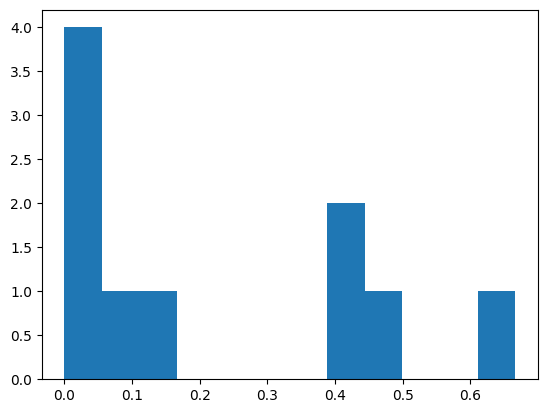


BETA SUMMARY:
beta initial:  [40. 40. 40. 40. 40. 40. 40. 40. 40. 40.]
beta final:  [20.    20.    19.642 19.638 20.    20.    20.    19.692 20.    19.792]


/home/dsemchin/Progression_models_simulations/EMDPM/visualization.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


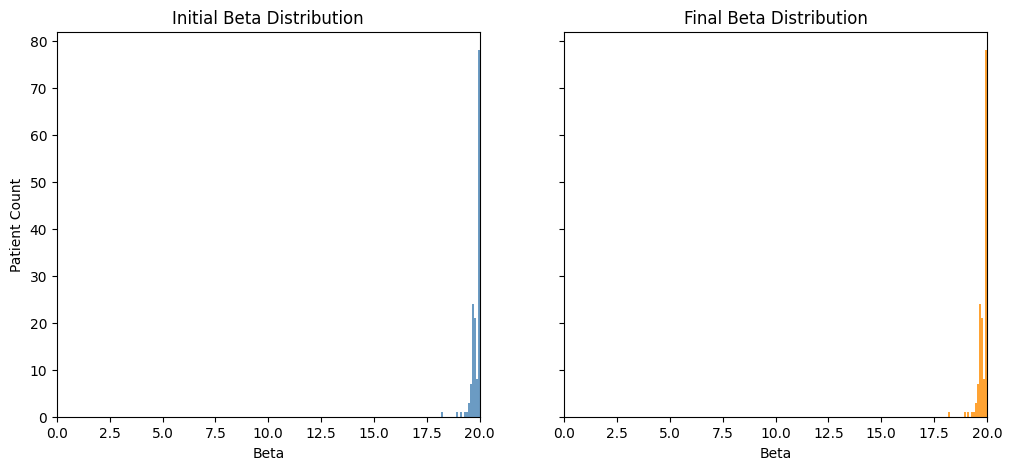

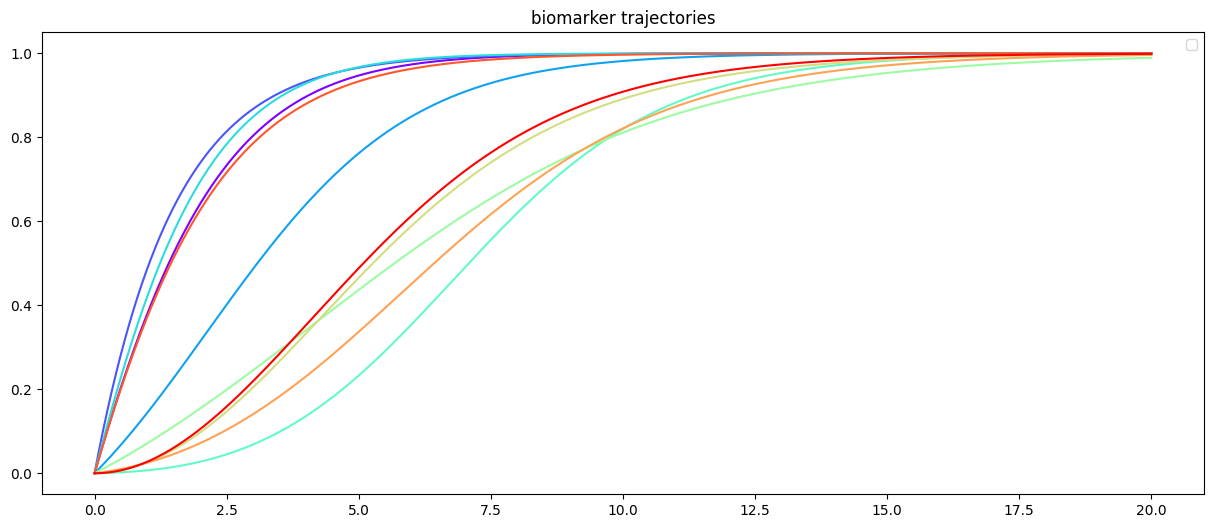

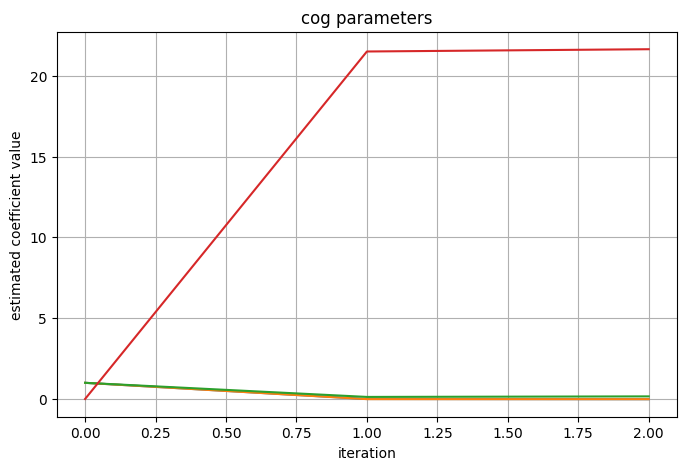

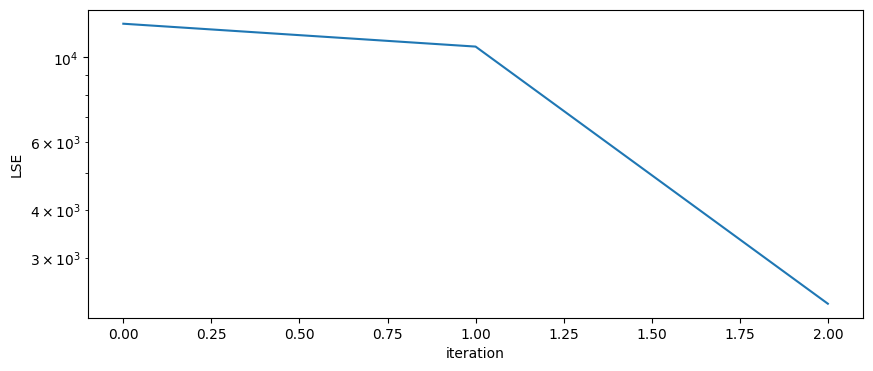

In [21]:
n_biomarkers = 10
t_span = np.linspace(0, t_max, int(t_max/step))

theta_history = em_model_2.theta_history
beta_history = em_model_2.beta_history
lse_history = em_model_2.lse_history

# final params
final_theta = theta_history[:,-1]
final_x0 = np.zeros(n_biomarkers)
final_f = final_theta[0:n_biomarkers]
final_s = final_theta[n_biomarkers:2*n_biomarkers]
final_scalar_K = final_theta[-1]
final_model = solve_system(final_x0, final_f, K, t_span, final_scalar_K)

initial_theta = theta_history[:,0]
initial_x0 = np.zeros(n_biomarkers)
initial_f = initial_theta[0:n_biomarkers]
initial_s = initial_theta[n_biomarkers:2*n_biomarkers]
initial_scalar_K = initial_theta[-1]
#initial_model = solve_system(initial_x0, initial_f, K, t_span, initial_scalar_K)

print("initial theta:")
print("f: ", np.round(initial_theta[:n_biomarkers], 3)[0:10])
print("s: ", np.round(initial_theta[n_biomarkers:2*n_biomarkers], 3)[0:10])
print("s_k: ", initial_theta[-1])

print("final theta:")
print("f: ", np.round(final_theta[:n_biomarkers], 3)[0:10])
print("s: ", np.round(final_theta[n_biomarkers:2*n_biomarkers], 3)[0:10])
print("s_k: ", final_theta[-1])

zeros = np.sum(final_theta[:n_biomarkers] == 0.0)
print(f"n_zeros: {zeros}")
plt.figure()
plt.hist(final_theta[:n_biomarkers], bins=12) 
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

axes[0].hist(beta_init, bins=20, color='steelblue', alpha=0.8)
axes[0].set_title("Initial Beta Distribution")
axes[0].set_xlabel("Beta")
axes[0].set_ylabel("Patient Count")
axes[0].set_xlim(0, t_span[-1])

axes[1].hist(beta_history[:,-1], bins=20, color='darkorange', alpha=0.8)
axes[1].set_title("Final Beta Distribution")
axes[1].set_xlabel("Beta")
axes[1].set_xlim(0, t_span[-1])

## Beta comparison:
print("\nBETA SUMMARY:")
print("beta initial: ", np.round(beta_history[0:10, 0], 3))
print("beta final: ", np.round(beta_history[0:10, -1], 3))

plot_biomarker_trajectories(final_model, t_span, n_biomarkers)
plot_cog_regression_history(em_model_2.cog_regression_history, ["MCATOT","TD_score","PIGD_score"])
plot_lse(lse_history[0:4])

In [ ]:
path = "/home/dsemchin/Progression_models_simulations/EMDPM/experiments/real_data_PPMI/ppmi_iter50_jac0_cog01_f05_sk1_betaREG"
em_model_3 = EM(num_iterations=50, t_max=t_max, step=step,
                 use_jacobian=False, lambda_cog=0.1, lambda_f=0.5, lambda_scalar=1)
em_model_3.fit(X=X, dt=dt, ids=ids, cog=cog, K=K, save_path=path, initial_beta=beta_init_reg)

initial conditions:
n_patients: 146, n_obs: 504
initial f: [0.02132917 0.0153129  0.06642505 0.06843318 0.09331644 0.075149
 0.09268624 0.09472834 0.0866778  0.0012602  0.04133209 0.08230453
 0.0022666  0.01390147 0.09860839 0.09937478 0.08214235 0.08432822
 0.04013177 0.06671307 0.08373361 0.09839783 0.02023919 0.03501122
 0.04284144 0.01783596 0.09961038 0.09075806 0.02514527 0.00911193
 0.08359398 0.01764515 0.01661423 0.07885973 0.07766215 0.04404987
 0.09696822 0.082177   0.05962018 0.00122331 0.05374854 0.04256232
 0.04619497 0.04704044 0.02556865 0.01364169 0.04599744 0.07974691
 0.07593373 0.03570143 0.06885477 0.07627636 0.07265386 0.08249544
 0.09601051 0.04935155 0.06479739 0.06791427 0.02254441 0.00444622
 0.03445908 0.07018692 0.06961764 0.09191688 0.02265776 0.09207324
 0.06548166 0.07676195]
initial s: [0.10711755 0.28260825 2.16554111 1.09902366 1.78421727 2.15874837
 1.36243194 1.69084338 2.16695433 1.00498682 0.94543585 1.55525368
 2.5998545  1.57441885 1.22037802 2.6

  4%|▍         | 2/50 [14:05<5:20:20, 400.43s/it]

  6%|▌         | 3/50 [14:16<2:54:25, 222.66s/it]

 88%|████████▊ | 44/50 [1:07:47<07:49, 78.27s/it]

initial theta:
f:  [0.021 0.015 0.066 0.068 0.093 0.075 0.093 0.095 0.087 0.001]
s:  [0.107 0.283 2.166 1.099 1.784 2.159 1.362 1.691 2.167 1.005]
s_k:  4.149
final theta:
f:  [0.    0.029 0.064 0.905 0.048 1.843 0.067 0.008 0.037 0.005]
s:  [2.386 2.335 2.437 1.898 3.137 2.624 2.323 2.639 2.205 2.156]
s_k:  1.9686325519747965
n_zeros: 11


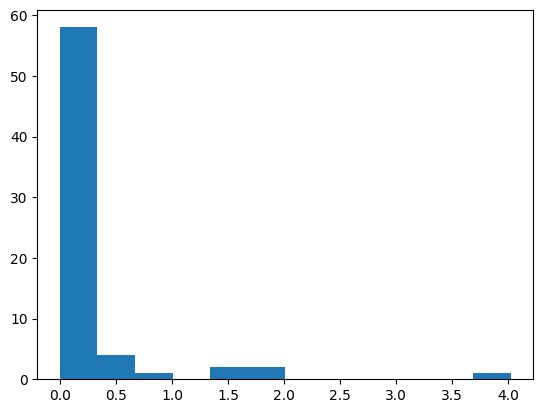


BETA SUMMARY:
beta initial:  [ 8. 20.  7.  7. 20. 20. 20. 20. 20. 20.]
beta final:  [ 8. 20.  7.  7. 20. 20. 20. 20. 20. 20.]


/home/dsemchin/Progression_models_simulations/EMDPM/visualization.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


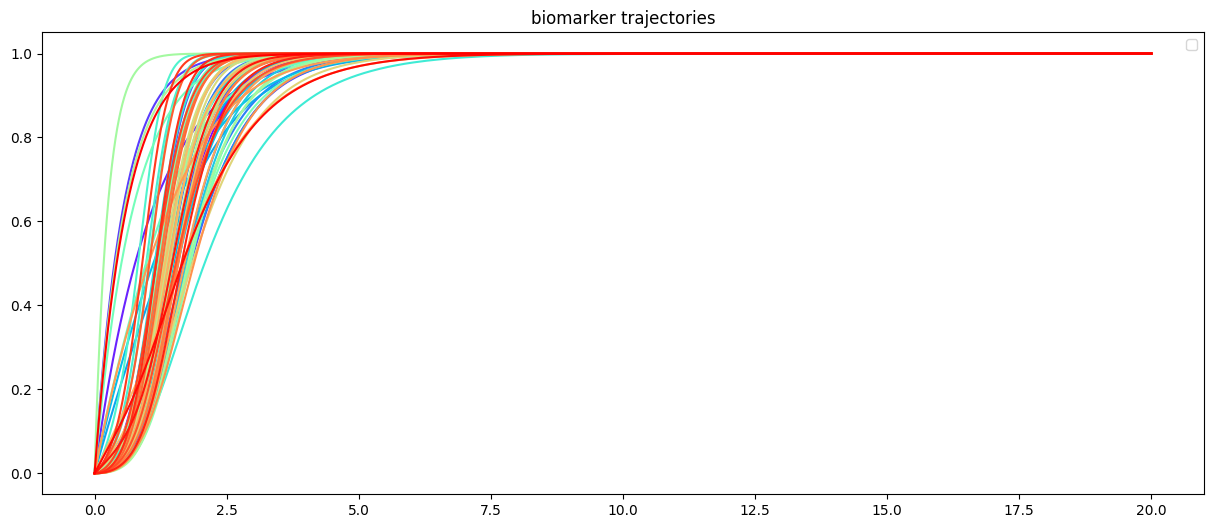

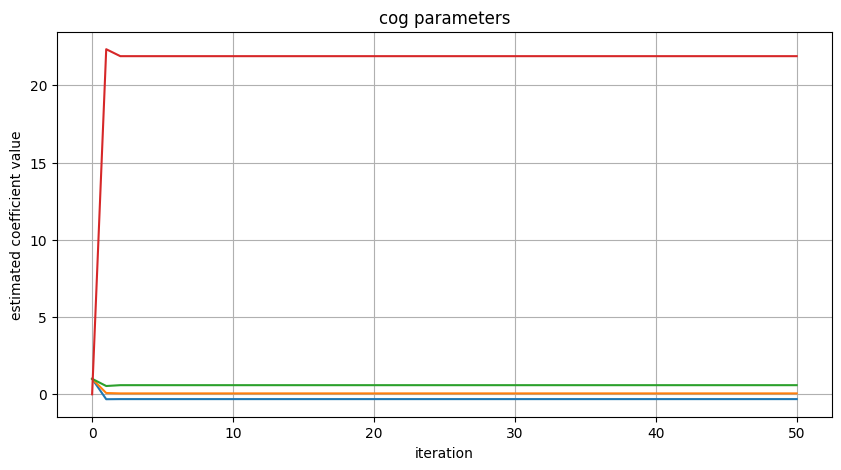

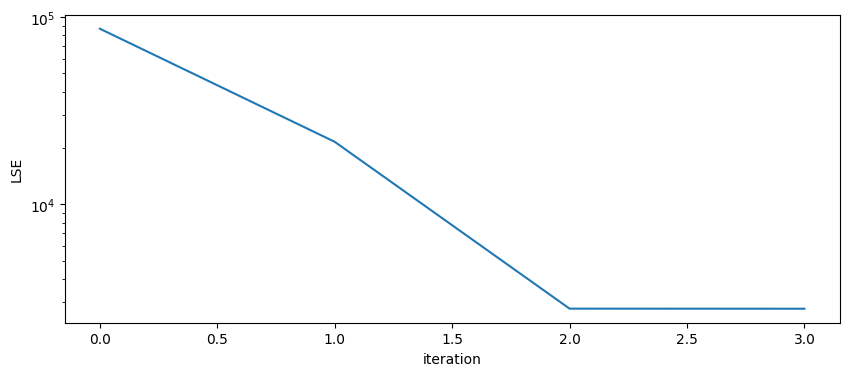

In [ ]:
n_biomarkers = 68
t_span = np.linspace(0, t_max, int(t_max/step))

theta_history = em_model_3.theta_history
beta_history = em_model_3.beta_history
lse_history = em_model_3.lse_history

# final params
final_theta = theta_history[:,-1]
final_x0 = np.zeros(n_biomarkers)
final_f = final_theta[0:n_biomarkers]
final_s = final_theta[n_biomarkers:2*n_biomarkers]
final_scalar_K = final_theta[-1]
final_model = solve_system(final_x0, final_f, K, t_span, final_scalar_K)

initial_theta = theta_history[:,0]
initial_x0 = np.zeros(n_biomarkers)
initial_f = initial_theta[0:n_biomarkers]
initial_s = initial_theta[n_biomarkers:2*n_biomarkers]
initial_scalar_K = initial_theta[-1]
#initial_model = solve_system(initial_x0, initial_f, K, t_span, initial_scalar_K)

print("initial theta:")
print("f: ", np.round(initial_theta[:n_biomarkers], 3)[0:10])
print("s: ", np.round(initial_theta[n_biomarkers:2*n_biomarkers], 3)[0:10])
print("s_k: ", initial_theta[-1])

print("final theta:")
print("f: ", np.round(final_theta[:n_biomarkers], 3)[0:10])
print("s: ", np.round(final_theta[n_biomarkers:2*n_biomarkers], 3)[0:10])
print("s_k: ", final_theta[-1])

zeros = np.sum(final_theta[:n_biomarkers] == 0.0)
print(f"n_zeros: {zeros}")
plt.figure()
plt.hist(final_theta[:n_biomarkers], bins=12) 
plt.show()

## Beta comparison:
print("\nBETA SUMMARY:")
print("beta initial: ", np.round(beta_history[0:10, 0], 3))
print("beta final: ", np.round(beta_history[0:10, -1], 3))

plot_biomarker_trajectories(final_model, t_span, n_biomarkers)
plot_cog_regression_history(em_model_3.cog_regression_history, ["MCATOT","TD_score","PIGD_score"])
plot_lse(lse_history[0:4])